# CNN Module_1 

## Imports

In [6]:
import librosa
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Extract the spectrogram of .wav files

In [7]:
# Function to extract Mel-spectrogram from the audio file
def extract_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None, duration=5.0)  # Limit to 5 seconds to keep data consistent
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels for better visualization
    return mel_spec_db

## Extract features / create training data

In [8]:
# Sample data 
data = pd.read_csv('csv_data/modified_csvs/preprocessed _data.csv')


# Define the unique instruments
unique_instruments = [1, 41, 42, 43, 61, 71, 72]  

if isinstance(data['target'].iloc[0], str):
    data['target'] = data['target'].apply(eval) 

mlb = MultiLabelBinarizer(classes=unique_instruments)

# # Apply MultiLabelBinarizer to the 'target' column to get the binary representation

# Extract features (Mel-spectrogram) and targets
X = []  # Features (Mel-spectrograms)
y = []  # Targets (binary labels)

for _, entry in data.iterrows():
    mel_spec = extract_mel_spectrogram(entry["filename"])
    X.append(mel_spec)
    
    # Use MultiLabelBinarizer to encode the target (list of instruments)
    encoded_target = mlb.fit_transform([entry["target"]])  # entry['target'] contains a list of instruments
    y.append(encoded_target[0])
    

# Pad the Mel-spectrograms to make them have the same shape (for CNN input)
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32', value=0)

# Add the channel dimension to X (since it is a grayscale image, the channel will be 1)
X = np.expand_dims(X, axis=-1)  # Shape will be (batch_size, height, width, 1)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [69, 74] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [7] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [44, 74] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [74] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [44] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/e

## Create / evaluate CNN model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers

# Define the CNN model
def create_cnn_model(shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=shape),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),  # Add Batch Normalization
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),          # Add Dropout with 30% rate
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision'])
    
    return model

# Define input shape based on Mel-spectrogram dimensions
input_shape = X_train.shape[1:]  # (height, width, channels), usually (time_steps, freq_bins, 1)
num_classes = y_train.shape[1]  # Number of instruments (output dimensions)

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=80,  # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Pass the early stopping callback
)

# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]:.4f}")  # Loss
print(f"Test Accuracy: {results[1]:.4f}")  # Accuracy
print(f"Test Precision: {results[2]:.4f}")  # Precision
print(f"Test Recall: {results[3]:.4f}")  # Recall

Epoch 1/80


/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.3445 - loss: 1.7555 - precision: 0.4813 - recall: 0.4928 - val_accuracy: 0.7656 - val_loss: 7.8731 - val_precision: 0.7656 - val_recall: 0.4667
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5038 - loss: 0.6805 - precision: 0.6033 - recall: 0.5668 - val_accuracy: 0.7656 - val_loss: 8.3366 - val_precision: 0.7656 - val_recall: 0.4667
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6155 - loss: 0.3986 - precision: 0.7655 - recall: 0.7452 - val_accuracy: 0.7656 - val_loss: 7.4496 - val_precision: 0.7656 - val_recall: 0.4667
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6654 - loss: 0.3041 - precision: 0.8040 - recall: 0.6710 - val_accuracy: 0.7656 - val_loss: 9.3440 - val_precision: 0.7656 - val_recall: 0.4667
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6861 - loss: 0.3127 - precision: 0.8014 - recall: 0.7252 - val_accuracy: 0.7656 - val_loss: 6.4929 - val_precision:

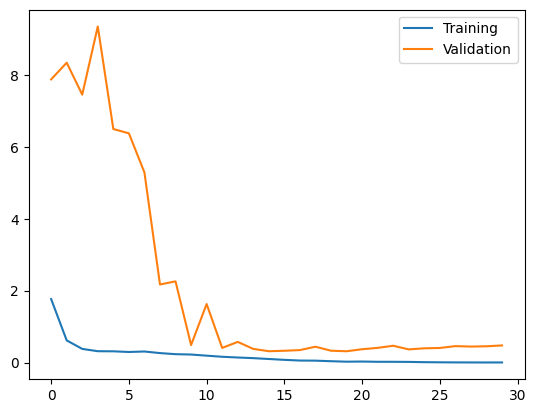

In [11]:
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.show()

## Prediction / Confusion matrix

In [14]:
# Function to predict instruments from a new .wav file
def predict_instruments(file_path, model, mlb):
    # Extract Mel-spectrogram from the input file
    mel_spec = extract_mel_spectrogram(file_path)
    
    # Pad or reshape the spectrogram to match the model input shape
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add channel dimension
    mel_spec = tf.keras.preprocessing.sequence.pad_sequences([mel_spec], padding='post', dtype='float32', value=0)
    
    # Predict the instruments
    prediction = model.predict(mel_spec)
    
    # Convert the binary predictions back to instrument labels
    predicted_instruments = mlb.inverse_transform((prediction > 0.5).astype(int))  # Threshold at 0.5 for multi-label
    return predicted_instruments[0]

# Example: Predict instruments in a new audio file
new_file_path = '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav'
predicted_instruments = predict_instruments(new_file_path, model, mlb)

print(f"Predicted instruments for '{new_file_path}': {predicted_instruments}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted instruments for '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav': (61, 71, 72)


In [15]:
# Directory containing test .wav files
wav_dir = 'test_data'

# Ground truth labels corresponding to each file
# This is a dictionary where the key is the file name, and the value is the true label
# For multi-label classification, use a binary array for each label
ground_truth = {
    '1759.wav': [1],
    '1819.wav': [61, 71, 72],
    '2106.wav': [41, 42, 43],
    '2191.wav': [41],
    '2298.wav': [43],
    '2303.wav': [1],
    '2382.wav': [41, 42, 43],
    '2416.wav': [61, 71, 72],
    '2556.wav': [1],
    '2628.wav': [1, 41],
                 
}

# Flatten all unique labels to determine the full set of classes
all_classes = sorted({label for labels in ground_truth.values() for label in labels})

# Initialize MultiLabelBinarizer with all possible classes
mlb = MultiLabelBinarizer(classes=all_classes)
mlb.fit([all_classes])  # Fit the binarizer

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Iterate through the files in the directory
for file_name in os.listdir(wav_dir):
    if file_name.endswith('.wav') and file_name in ground_truth:
        file_path = os.path.join(wav_dir, file_name)
        
        # Predict instruments for the current file
        predicted_instruments = predict_instruments(file_path, model, mlb)
        
        # Append true and predicted labels (as binary arrays)
        y_true.append(mlb.transform([ground_truth[file_name]])[0])  # Convert true labels to binary array
        y_pred.append(mlb.transform([predicted_instruments])[0])    # Convert predicted labels to binary array

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Print individual confusion matrices for each class
for i, (label, cm) in enumerate(zip(mlb.classes_, mcm)):
    print(f"Confusion Matrix for class {label}:\n{cm}")

# Generate classification report for overall evaluation
report = classification_report(y_true, y_pred, target_names=[str(label) for label in mlb.classes_])
print("\nClassification Report:\n")
print(report)

# # Plot confusion matrix for each class
# for i, (label, cm) in enumerate(zip(mlb.classes_, mcm)):
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not "+str(label), str(label)], yticklabels=["Not "+str(label), str(label)])
#     plt.title(f"Confusion Matrix for Class {label}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Confusion Matrix for class 1:
[[5 1]
 [0 4]]
Confusion Matrix for class 41:
[[5 1]
 [0 4]]
Confusion Matrix for class 42:
[[6 2]
 [0 2]]
Confusion Matrix for class 43:
[[5 2]
 [0 3]]
Confusion Matrix for class 61:
[[8 0]
 [0 2]]
Confusion Matrix for class 71:
[[8 0]
 [0 2]]
Confusion Matrix for class 72:
[[8 0]
 [0 2]]

Classification Report:

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
          41       0.80      1.00      0.89         4
          42       0.50      1.00      0.67         2
          43       0.60      1.00      0.75         3
   

## Save the model

In [22]:
ls CNN_model1

ls: CNN_model1: No such file or directory


In [24]:
# Save the model in TensorFlow's SavedModel format
model.save('Models/CNN_model1.keras')

## Load saved the model

In [26]:
from tensorflow.keras.models import load_model

# Load the .keras file
saved_model = load_model('Models/CNN_model1.keras')

In [28]:
# Example: Predict instruments in a new audio file
new_file_path = '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav'
predicted_instruments = predict_instruments(new_file_path, saved_model, mlb)
print(f"Predicted instruments for '{new_file_path}': {predicted_instruments}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted instruments for '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav': (61, 71, 72)
